In [ ]:
using Plots
using LinearAlgebra
using Random
using MAT
using JLD
using StatsPlots
using StatsBase
using ProgressMeter
using ParallelKMeans
include("../alpcahus.jl")
include("../cluster.jl")
include("../otherMethods.jl")
include("../adssc.jl")
include("../helperFunctions.jl")

IOU (generic function with 1 method)

# Data

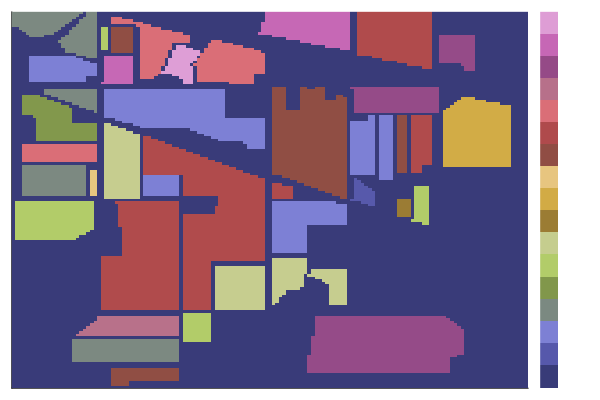

In [2]:
heatmap(matread("truth.mat")["indian_pines_gt"], c = palette(:tab20b, 17), yflip=true, xticks=false, yticks=false, colorbar_ticks=false)
#savefig("labels.svg")

In [3]:
K = 16; d= 5;
C = matread("truth.mat")["indian_pines_gt"]
Ct = vec(reshape(C, 145*145, 1))
Ct = Ct[Ct .> 0]
Yt = load("data.jld", "data");
size(Yt)

(200, 10249)

# Kmeans

In [4]:
kmean = kmeans(Elkan(), Yt, K; k_init="k-means++")
C_kmeans = kmean.assignments
C_kmeans = hungarianAlgorithm(Ct, C_kmeans)
clusterError(Ct, C_kmeans)

78.65157576348912

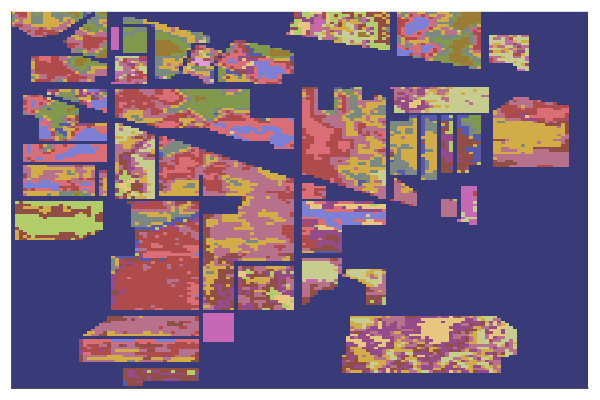

In [5]:
C_map = zeros(145*145)
C_map[vec(C) .> 0] = C_kmeans
C_map = reshape(C_map, 145, 145);
heatmap(C_map, c = palette(:tab20b, 17), colorbar_ticks=false, yflip=true, xticks=false, yticks=false, colorbar=false)
#savefig("kmeans.pdf")

In [6]:
IOU(vec(C_map), vec(C), K)

0.15345166540042843

# ALPCAHUS

In [42]:
idx = sample(Xoshiro(123), 1:10249, 10249, replace=false);
idx1 = idx[1:2500]
idx2 = idx[2501:end]
Yt_train = Yt[:, idx1]
Ct_train = Ct[idx1];
Yt_test = Yt[:, idx2]
Ct_test = Ct[idx2];

In [43]:
C_alpcahus = ALPCAHUS(Yt_train, K, 5*ones(Int,K); B=32, q=16, T=3, alpcahIter=5, subspaceMethod=:alpcah, spectralStart=false, finalStep=false)
clusterError(Ct_train, C_alpcahus)

53.12

In [44]:
S = []
for k=1:K
    println(size(Yt_train[:, C_alpcahus .== k]))
    U = fastALPCAH(Yt_train[:, C_alpcahus .== k], d; alpcahIter=10) #fastPCA(Yt[:, Ct .== k], 5) #fastALPCAH(Yt[:, Ct .== k], 20; alpcahIter=10)
    push!(S, U)
end
C_alpcahus2 = clusterAssignment(Yt, S, K)
C_alpcahus2 = hungarianAlgorithm(Ct, C_alpcahus2)
clusterError(Ct, C_alpcahus2)

(200, 30)
(200, 41)
(200, 60)
(200, 318)
(200, 44)
(200, 671)
(200, 119)
(200, 61)
(200, 33)
(200, 235)
(200, 139)
(200, 83)
(200, 198)
(200, 249)
(200, 140)
(200, 79)


56.17133378866231

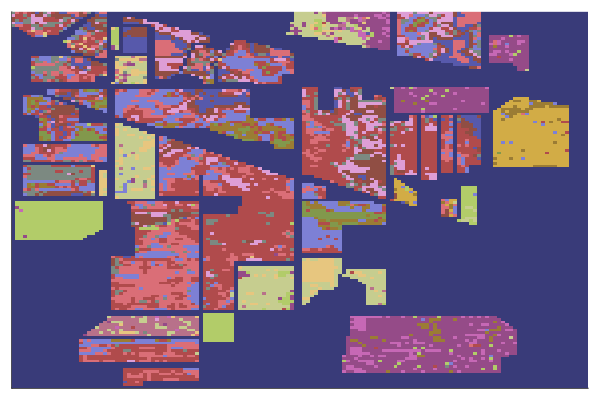

In [45]:
C_map = zeros(145*145)
C_map[vec(C) .> 0] = C_alpcahus2
C_map = reshape(C_map, 145, 145);
heatmap(C_map, xticks=false, yticks=false, colorbar=false, c = palette(:tab20b, 17), colorbar_ticks=false, yflip=true)
#savefig("alpcahus.svg")

In [46]:
IOU(vec(C_map), vec(C), K)

0.34666456871786583

# K-Subspaces

In [54]:
C_ekss = ALPCAHUS(Yt_train, K, d*ones(Int,K); B=32, T=3, alpcahIter=5, subspaceMethod=:pca, spectralStart=false, finalStep=false)
S = []
for k=1:K
    U = fastPCA(Yt_train[:, C_ekss .== k], d)
    push!(S, U)
end
C_ekss2 = clusterAssignment(Yt, S, K)
C_ekss2 = hungarianAlgorithm(Ct, C_ekss2)
clusterError(Ct, C_ekss2)

60.07415357595863

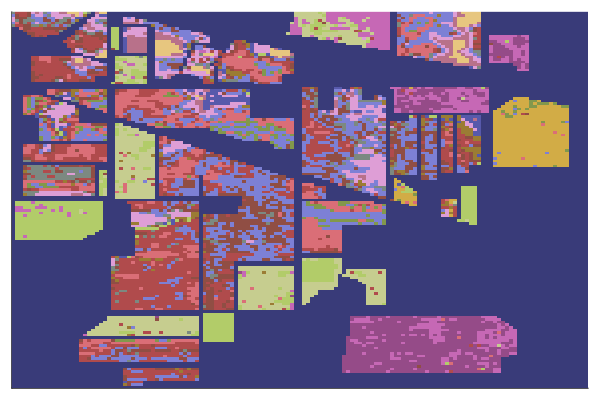

In [55]:
C_map = zeros(145*145)
C_map[vec(C) .> 0] = C_ekss2
C_map = reshape(C_map, 145, 145);
heatmap(C_map, xticks=false, yticks=false, colorbar=false, c = palette(:tab20b, 17), colorbar_ticks=false, yflip=true)
#savefig("ekss.svg")

In [56]:
IOU(vec(C_map), vec(C), K)

0.29019570883607754

# Noise Estimation

In [35]:
# function getVariances(Y, k)
#     Y = Y .- mean(Y, dims=2)
#     Y = Y ./ std(Y, dims=2);
#     U_ALPCAH = fastALPCAH( Y , k ; alpcahIter=10)
#     v = grouplessVarianceUpdate(Y , U_ALPCAH*U_ALPCAH'*Y)
#     return v
# end

 # 	Class 	Samples
1 	Alfalfa 	46 

2 	Corn-notill 	1428

3 	Corn-mintill 	830

4 	Corn 	237

5 	Grass-pasture 	483

6 	Grass-trees 	730

7 	Grass-pasture-mowed 	28

8 	Hay-windrowed 	478

9 	Oats 	20

10 	Soybean-notill 	972

11 	Soybean-mintill 	2455

12 	Soybean-clean 	593

13 	Wheat 	205

14 	Woods 	1265

15 	Buildings-Grass-Trees-Drives 	386

16 	Stone-Steel-Towers 	93 

In [36]:
# v1 = getVariances(Yt[:, C_alpcahus2 .== 4], 5)
# v2 = getVariances(Yt[:, C_alpcahus2 .== 14], 5)
# v3 = getVariances(Yt[:, C_alpcahus2 .== 11], 5)
# p1 = plot(sort((v1)), yaxis=:log10, label="corn", linewidth=3, color=:red, legend=:topleft);
# p2 = plot(sort((v2)), yaxis=:log10, label="woods", linewidth=3, color=:blue, legend=:topleft);
# p3 = plot(sort((v3)), yaxis=:log10, label="hay", linewidth=3, color=:green, legend=:topleft);
# plot(p1,p2,p3, layout = (3,1) )